# Dealing with missing data: An exploration
We have two incomplete videos, taken at different framerates.  
We want to build a meaningful comparison between them.  
This notebook explores the way that we do that.  

In [1]:
import pandas as pd

## Create some fake data
Note that we start with _timestamps_, not a frame number.  
When comparing between different framerates, the time is the only thing that matters - the _instant_ that the data was taken.  

In [2]:
fps500 = (
    pd.timedelta_range(start="0s", end="0.1s", periods=50, name="instant")
    .to_frame(index=False)
    .set_index("instant")
)

fps600 = (
    pd.timedelta_range(start="0s", end="0.1s", periods=60, name="instant")
    .to_frame(index=False)
    .set_index("instant")
)

fps500["Reference"] = range(1, 51) # Make up some fake, monotonic data, highlighting any artifacting
fps600["Substrate"] = range(1, 61)

### Let's have a look at what we've created

In [3]:
fps500.head()

,Reference
instant,
0 days 00:00:00,1
0 days 00:00:00.002040816,2
0 days 00:00:00.004081632,3
0 days 00:00:00.006122448,4
0 days 00:00:00.008163265,5


In [4]:
fps600.head()

,Substrate
instant,
0 days 00:00:00,1
0 days 00:00:00.001694915,2
0 days 00:00:00.003389830,3
0 days 00:00:00.005084745,4
0 days 00:00:00.006779661,5


## Let's bring our two videos together, and put them in time-order
We see that we have missing values.  
This may be workable/ideal if we want to fit some curve to this data with respect to elapsed time (in which case we don't need to perform any merge or interpolation).  

In [5]:
pd.concat([fps500, fps600]).sort_index().head()


,Reference,Substrate
instant,,
0 days 00:00:00,1.0,NaN
0 days 00:00:00,NaN,1.0
0 days 00:00:00.001694915,NaN,2.0
0 days 00:00:00.002040816,2.0,NaN
0 days 00:00:00.003389830,NaN,3.0


## Timeseries-friendly merging
Pandas has [Timeseries-friendly merging](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#timeseries-friendly-merging).  
In particular, the [`merge_asof`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html#pandas.merge_asof) operation seems particularly well suited to our application.  
In the example below, we take a copy of `fps500`, and add a column containing data from `fps600`. We effectively *downsample* the latter to match the former, filling in missing values with the nearest one.  
I think this is our best option.

In [6]:
merged = pd.merge_asof(
    left=fps500,
    right=fps600,
    left_index=True,  # Use the indexes to merge
    right_index=True,
    direction="nearest",  # Fill in missing values in the left with the one closest (in time) from the right
    tolerance=pd.Timedelta(
        value=1, unit="milliseconds"
    ),  # Only fill in if the data is within this time period. Especially useful for sparse data (which we will have)
)
merged.head()


,Reference,Substrate
instant,,
0 days 00:00:00,1,1
0 days 00:00:00.002040816,2,2
0 days 00:00:00.004081632,3,3
0 days 00:00:00.006122448,4,5
0 days 00:00:00.008163265,5,6


This does result in stepping in the resampled column, which is potentially undesirable depending on the downstream analytical techniques.  

<AxesSubplot:xlabel='instant'>

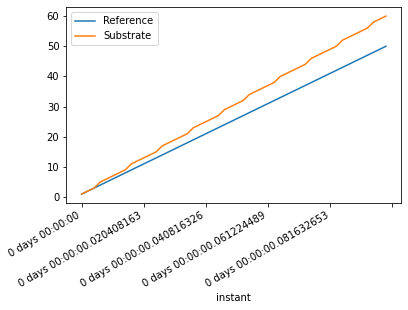

In [7]:
merged.plot()

## Manual interpolation and resampling
We begin with our naive combination of our timeseries, and then [`interpolate`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html). 
(Note that a variety of interpolation methods are available).  
This fills _every_ missing value with an interpolated result from the surrounding values. 
Ideally the filled in values will be weighted according to timestamp.  
This results in data with reduced stepping.  

In [8]:
df = pd.concat([fps500, fps600]).sort_index()
df.head()

,Reference,Substrate
instant,,
0 days 00:00:00,1.0,NaN
0 days 00:00:00,NaN,1.0
0 days 00:00:00.001694915,NaN,2.0
0 days 00:00:00.002040816,2.0,NaN
0 days 00:00:00.003389830,NaN,3.0


In [9]:
interpolated = df.interpolate(method="linear")
interpolated.head()

,Reference,Substrate
instant,,
0 days 00:00:00,1.000000,NaN
0 days 00:00:00,1.333333,1.0
0 days 00:00:00.001694915,1.666667,2.0
0 days 00:00:00.002040816,2.000000,2.5
0 days 00:00:00.003389830,2.500000,3.0


<AxesSubplot:xlabel='instant'>

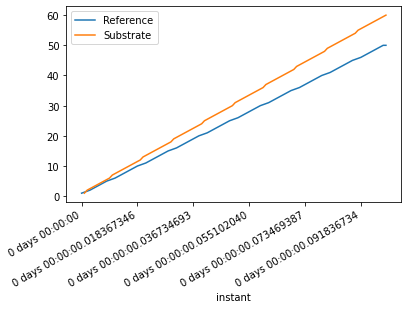

In [10]:
interpolated.plot()

However, it does leave us with irregularly spaced data - that is, the time between each record isn't the same for each record.  
We can address this be [`resample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)-ing, but that leaves us *another* operation away from the underlying data.  
In this example we take the mean of every 2ms window in our data.  
Smaller intervals lead to gaps in data, so there must be tuning, or a decision to be made about filling in those gaps.  
In the plot, we see that both series are disrupted.

In [11]:
interpolated.index.to_frame(index=False).diff().head()

,instant
0,NaT
1,0 days 00:00:00
2,0 days 00:00:00.001694915
3,0 days 00:00:00.000345901
4,0 days 00:00:00.001349014


In [12]:
interval = pd.Timedelta(value=2, unit="milliseconds")
interpolated_resampled = interpolated.resample(interval).mean()
interpolated_resampled.head()

,Reference,Substrate
instant,,
0 days 00:00:00,1.333333,1.50
0 days 00:00:00.002000,2.250000,2.75
0 days 00:00:00.004000,3.250000,3.75
0 days 00:00:00.006000,4.250000,4.75
0 days 00:00:00.008000,5.166667,5.75


<AxesSubplot:xlabel='instant'>

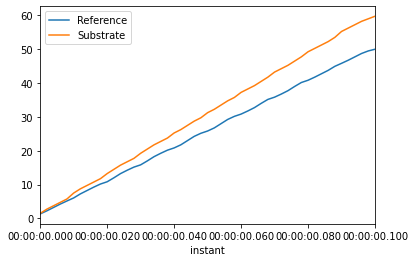

In [13]:
interpolated_resampled.plot()

## Single-operation resampling of each time-series
We can reduce the number of indirections away from ground truth be resampling each time-series to a common frequency.  
However, this, again, is an operation that must be tuned - we have limited options for interpolating here (e.g `mean`).  
Note - it is possible we could do our own interpolation, which would require further investigation

In [14]:
interval = pd.Timedelta(2, "milliseconds")

resampled_500 = fps500.resample(interval).mean()
resampled_600 = fps600.resample(interval).mean()

combined = pd.merge(resampled_500, resampled_600, left_index=True, right_index=True)
combined.head()


,Reference,Substrate
instant,,
0 days 00:00:00,1.0,1.5
0 days 00:00:00.002000,2.0,3.0
0 days 00:00:00.004000,3.0,4.0
0 days 00:00:00.006000,4.0,5.0
0 days 00:00:00.008000,5.0,6.0


<AxesSubplot:xlabel='instant'>

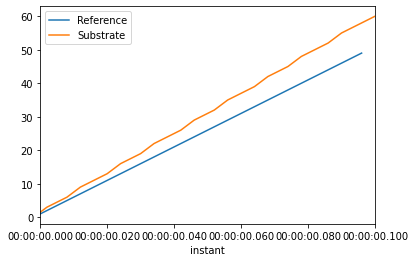

In [15]:
combined.plot()